In [ ]:
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 48.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=4ae4c176cdf70af09cacca0ef21f1ea7ccdc08eb19870bbbe33ebadad9318c73
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Prediction with PySpark").getOrCreate()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
%matplotlib inline

In [ ]:
import pyspark.ml as ml

In [ ]:
# Load the dataset
telecom_df  = spark.read.csv('churn.csv',inferSchema=True,header=True)

In [ ]:
telecom_df.show(5, truncate=False)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|state|account length|area code|phone number|international plan|voice mail plan|number vmail messages|total day minutes|total day calls|total day charge|total eve minutes|total eve calls|total eve charge|total night minutes|total night calls|total night charge|total intl minutes|total intl calls|total intl charge|customer service calls|churn|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-------------

In [ ]:
refined_column_name = ["state","account_length","area_code","phone_number","international_plan","voice_mail_plan","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","customer_service_calls","churn"]
telecom_df_new = telecom_df.toDF(*refined_column_name)

In [ ]:
telecom_df_new.printSchema()

root
 |-- state: string (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: integer (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- customer_service_calls: integer (nullable = true)
 |-- churn: boolean (nullable 

In [ ]:
telecom_df_new.show(5)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|customer_service_calls|churn|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-------------

In [ ]:
#Keep a copy of the original dataframe for later use
telecom_df_new_1 = telecom_df_new

In [ ]:
telecom_df_new1 = telecom_df_new.toPandas()

In [ ]:
telecom_df_new1['churn'] = telecom_df_new1['churn'].astype(int)

In [ ]:
telecom_df_new1.international_plan = telecom_df_new1.international_plan.map(dict(yes=1,no=0))

In [ ]:
telecom_df_new1.voice_mail_plan = telecom_df_new1.voice_mail_plan.map(dict(yes=1,no=0))

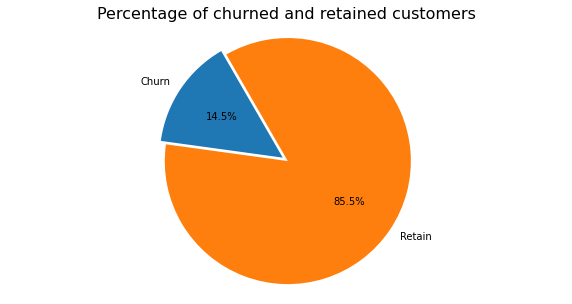

In [ ]:
# Displaying the percentage of churned and retained customers 
labels = 'Churn', 'Retain'
sizes = [telecom_df_new1.churn[telecom_df_new1['churn'] == 1].count(), telecom_df_new1.churn[telecom_df_new1['churn'] == 0].count()]
explode = (0, 0.05)
fig1, ax1 = plt.subplots(figsize = (10, 5))
ax1.pie(sizes, explode=explode, labels = labels, autopct='%1.1f%%',
        shadow = False, startangle = 120)
ax1.axis('equal')
plt.title('Percentage of churned and retained customers', size = 16)
plt.show()

In [ ]:
telecom_df_new1 = telecom_df_new1.drop('phone_number',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
telecom_df_new1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int32  
 2   area_code               3333 non-null   int32  
 3   international_plan      3333 non-null   int64  
 4   voice_mail_plan         3333 non-null   int64  
 5   number_vmail_messages   3333 non-null   int32  
 6   total_day_minutes       3333 non-null   float64
 7   total_day_calls         3333 non-null   int32  
 8   total_day_charge        3333 non-null   float64
 9   total_eve_minutes       3333 non-null   float64
 10  total_eve_calls         3333 non-null   int32  
 11  total_eve_charge        3333 non-null   float64
 12  total_night_minutes     3333 non-null   float64
 13  total_night_calls       3333 non-null   int32  
 14  total_night_charge      3333 non-null   

In [ ]:
# Changing Pandas date frane to Spark Data Frame 

final_spark_df = spark.createDataFrame(telecom_df_new1)
type(final_spark_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
from pyspark.sql.types import IntegerType, BooleanType, DateType

In [ ]:
telecom_df_new_1.withColumn("churn", telecom_df_new_1.churn.cast(IntegerType()))

DataFrame[state: string, account_length: int, area_code: int, phone_number: string, international_plan: string, voice_mail_plan: string, number_vmail_messages: int, total_day_minutes: double, total_day_calls: int, total_day_charge: double, total_eve_minutes: double, total_eve_calls: int, total_eve_charge: double, total_night_minutes: double, total_night_calls: int, total_night_charge: double, total_intl_minutes: double, total_intl_calls: int, total_intl_charge: double, customer_service_calls: int, churn: int]

In [ ]:
telecom_df_new_1.show()

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|customer_service_calls|churn|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-------------

In [ ]:
telecom_df_new_1 = telecom_df_new_1.drop("area_code")

In [ ]:
telecom_df_new_1 = telecom_df_new_1.drop("total_day_minutes","total_day_charge")

In [ ]:
telecom_df_new_1 = telecom_df_new_1.drop("total_eve_minutes","total_eve_charge","total_night_minutes","total_night_charge","total_intl_minutes","total_intl_charge")

In [ ]:
telecom_df_new_1.show(2)

+-----+------------------+---------------+---------------------+---------------+---------------+-----------------+----------------+----------------------+-----+
|state|international_plan|voice_mail_plan|number_vmail_messages|total_day_calls|total_eve_calls|total_night_calls|total_intl_calls|customer_service_calls|churn|
+-----+------------------+---------------+---------------------+---------------+---------------+-----------------+----------------+----------------------+-----+
|   KS|                no|            yes|                   25|            110|             99|               91|               3|                     1|false|
|   OH|                no|            yes|                   26|            123|            103|              103|               3|                     1|false|
+-----+------------------+---------------+---------------------+---------------+---------------+-----------------+----------------+----------------------+-----+
only showing top 2 rows



In [ ]:
#Columns that will be used as features and their types
continuous_features = ['total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls','customer_service_calls']
                    
categorical_features = ['state', 'international_plan','voice_mail_plan']

In [ ]:
#Encoding all categorical features
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer

In [ ]:
# create object of StringIndexer class and specify input and output column
SI_state = StringIndexer(inputCol='state',outputCol='state_Index2')
SI_international_plan = StringIndexer(inputCol='international_plan',outputCol='international_plan_Index2')
SI_voice_mail_plan = StringIndexer(inputCol='voice_mail_plan',outputCol='voice_mail_plan_Index2')

# transform the data
telecom_df_new_1= SI_state.fit(telecom_df_new_1).transform(telecom_df_new_1)
telecom_df_new_1 = SI_international_plan.fit(telecom_df_new_1).transform(telecom_df_new_1)
telecom_df_new_1 = SI_voice_mail_plan.fit(telecom_df_new_1).transform(telecom_df_new_1)

# view the transformed data
telecom_df_new_1.select('state', 'state_Index2', 'international_plan', 'international_plan_Index2', 'voice_mail_plan', 'voice_mail_plan_Index2').show(10)


+-----+------------+------------------+-------------------------+---------------+----------------------+
|state|state_Index2|international_plan|international_plan_Index2|voice_mail_plan|voice_mail_plan_Index2|
+-----+------------+------------------+-------------------------+---------------+----------------------+
|   KS|        16.0|                no|                      0.0|            yes|                   1.0|
|   OH|         4.0|                no|                      0.0|            yes|                   1.0|
|   NJ|        20.0|                no|                      0.0|             no|                   0.0|
|   OH|         4.0|               yes|                      1.0|             no|                   0.0|
|   OK|        35.0|               yes|                      1.0|             no|                   0.0|
|   AL|         3.0|               yes|                      1.0|             no|                   0.0|
|   MA|        24.0|                no|                

In [ ]:
# create object and specify input and output column
OHE = OneHotEncoder(inputCols=['state_Index2', 'international_plan_Index2','voice_mail_plan_Index2'],outputCols=['state_vec', 'international_plan_vec','voice_mail_plan_vec'])

# transform the data
telecom_df_new_1 = OHE.fit(telecom_df_new_1).transform(telecom_df_new_1)

# view and transform the data
telecom_df_new_1.select('state', 'state_Index2', 'state_vec', 'international_plan', 'international_plan_Index2', 'international_plan_vec','voice_mail_plan', 'voice_mail_plan_Index2', 'voice_mail_plan_vec').show(10)

+-----+------------+---------------+------------------+-------------------------+----------------------+---------------+----------------------+-------------------+
|state|state_Index2|      state_vec|international_plan|international_plan_Index2|international_plan_vec|voice_mail_plan|voice_mail_plan_Index2|voice_mail_plan_vec|
+-----+------------+---------------+------------------+-------------------------+----------------------+---------------+----------------------+-------------------+
|   KS|        16.0|(50,[16],[1.0])|                no|                      0.0|         (1,[0],[1.0])|            yes|                   1.0|          (1,[],[])|
|   OH|         4.0| (50,[4],[1.0])|                no|                      0.0|         (1,[0],[1.0])|            yes|                   1.0|          (1,[],[])|
|   NJ|        20.0|(50,[20],[1.0])|                no|                      0.0|         (1,[0],[1.0])|             no|                   0.0|      (1,[0],[1.0])|
|   OH|         

In [ ]:
#Create vectors from all features column
featureCols = continuous_features + ['state_vec',   'international_plan_vec','voice_mail_plan_vec']    
                                   

In [ ]:
assembler = VectorAssembler( inputCols = featureCols, outputCol = "features")

In [ ]:
telecom_train_df = assembler.transform( telecom_df_new_1 )

In [ ]:
telecom_train_df = telecom_train_df.withColumn('label', telecom_train_df['churn'].cast('integer'))

In [ ]:
#Split the dataset
train_df, test_df = telecom_train_df.randomSplit( [0.7, 0.3], seed = 42 )

In [ ]:
telecom_train_df.show(5)

+-----+------------------+---------------+---------------------+---------------+---------------+-----------------+----------------+----------------------+-----+-----------+------------------------+---------------------+------------+-------------------------+----------------------+------------+-------------------------+----------------------+---------------+----------------------+-------------------+--------------------+-----+
|state|international_plan|voice_mail_plan|number_vmail_messages|total_day_calls|total_eve_calls|total_night_calls|total_intl_calls|customer_service_calls|churn|state_Index|international_plan_Index|voice_mail_plan_Index|state_Index1|international_plan_Index1|voice_mail_plan_Index1|state_Index2|international_plan_Index2|voice_mail_plan_Index2|      state_vec|international_plan_vec|voice_mail_plan_vec|            features|label|
+-----+------------------+---------------+---------------------+---------------+---------------+-----------------+----------------+---------

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
#linreg = LinearRegression(maxIter=500, regParam=0.0)
linreg = LogisticRegression()

In [ ]:
lm = linreg.fit( train_df )

In [ ]:
#Make predictions on train data and evaluate
y_pred_train = lm.transform(train_df)

In [ ]:
#Make predictions on test data and evaluate
y_pred_test = lm.transform( test_df )

In [ ]:
y_pred_test.show(10)

+-----+------------------+---------------+---------------------+---------------+---------------+-----------------+----------------+----------------------+-----+-----------+------------------------+---------------------+------------+-------------------------+----------------------+------------+-------------------------+----------------------+---------------+----------------------+-------------------+--------------------+-----+--------------------+--------------------+----------+
|state|international_plan|voice_mail_plan|number_vmail_messages|total_day_calls|total_eve_calls|total_night_calls|total_intl_calls|customer_service_calls|churn|state_Index|international_plan_Index|voice_mail_plan_Index|state_Index1|international_plan_Index1|voice_mail_plan_Index1|state_Index2|international_plan_Index2|voice_mail_plan_Index2|      state_vec|international_plan_vec|voice_mail_plan_vec|            features|label|       rawPrediction|         probability|prediction|
+-----+------------------+--------

In [ ]:
y_pred_test.select( 'features',  'label', 'prediction', 'churn' ).show( 5 )

+--------------------+-----+----------+-----+
|            features|label|prediction|churn|
+--------------------+-----+----------+-----+
|(57,[0,1,2,3,4,51...|    0|       0.0|false|
|(57,[0,1,2,3,4,51...|    0|       0.0|false|
|(57,[0,1,2,3,4,51...|    0|       0.0|false|
|(57,[0,1,2,3,4,51...|    0|       0.0|false|
|(57,[0,1,2,3,4,51...|    0|       0.0|false|
+--------------------+-----+----------+-----+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter = 10, featuresCol='features', labelCol='label')
gbt_model = gbt.fit(train_df)

In [ ]:
predictions = gbt_model.transform(test_df)

In [ ]:
predictions.show(5)

+-----+------------------+---------------+---------------------+---------------+---------------+-----------------+----------------+----------------------+-----+-----------+------------------------+---------------------+------------+-------------------------+----------------------+------------+-------------------------+----------------------+---------------+----------------------+-------------------+--------------------+-----+--------------------+--------------------+----------+
|state|international_plan|voice_mail_plan|number_vmail_messages|total_day_calls|total_eve_calls|total_night_calls|total_intl_calls|customer_service_calls|churn|state_Index|international_plan_Index|voice_mail_plan_Index|state_Index1|international_plan_Index1|voice_mail_plan_Index1|state_Index2|international_plan_Index2|voice_mail_plan_Index2|      state_vec|international_plan_vec|voice_mail_plan_vec|            features|label|       rawPrediction|         probability|prediction|
+-----+------------------+--------

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
accuracy

0.8814814814814815

In [ ]:
print('Accuracy = %g' % (accuracy))

Accuracy = 0.881481
